In [1]:
import sys
sys.executable


'c:\\Users\\cj_li\\OneDrive\\Py Scripts\\GitHub\\cool_routes\\.venv\\Scripts\\python.exe'

In [2]:
import importlib.util
print(importlib.util.find_spec("pandas"))


ModuleSpec(name='pandas', loader=<_frozen_importlib_external.SourceFileLoader object at 0x0000023C56DD7310>, origin='c:\\Users\\cj_li\\OneDrive\\Py Scripts\\GitHub\\cool_routes\\.venv\\Lib\\site-packages\\pandas\\__init__.py', submodule_search_locations=['c:\\Users\\cj_li\\OneDrive\\Py Scripts\\GitHub\\cool_routes\\.venv\\Lib\\site-packages\\pandas'])


In [3]:
import ee
import osmnx as ox
import geopandas as gpd
import pandas as pd
from shapely.geometry import mapping, Polygon
import json
import sys
import folium
import numpy as np

# Gráfico
import matplotlib.pyplot as plt

In [ ]:
# Rasterio and Geopandas for raster data handling
import rasterio
from rasterio.features import shapes
import geopandas as gpd
import numpy as np
from shapely.geometry import shape

## Carga de datos

In [2]:
altura_edi = gpd.read_file('buildings_heights_quilicura_2.shp').rename(columns={'mean':'altura'})
altura_edi.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 6028 entries, 0 to 6027
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   OBJECTID    6028 non-null   int64   
 1   id          6028 non-null   object  
 2   altura      6028 non-null   float64 
 3   original_o  6028 non-null   object  
 4   Shape_Leng  6028 non-null   float64 
 5   Shape_Area  6028 non-null   float64 
 6   geometry    6028 non-null   geometry
dtypes: float64(3), geometry(1), int64(1), object(2)
memory usage: 329.8+ KB


### Calcular ángulo solar con pysolar

In [3]:
from pysolar.solar import get_altitude, get_azimuth
from datetime import datetime
import pytz

# Ubicación aproximada (Santiago)
lat = -33.45
lon = -70.65
fecha = datetime(2024, 1, 15, 15, 0, 0, tzinfo=pytz.timezone('America/Santiago'))

# Ángulo solar de elevación y azimut
elevacion_sol = get_altitude(lat, lon, fecha)
azimut_sol = get_azimuth(lat, lon, fecha)


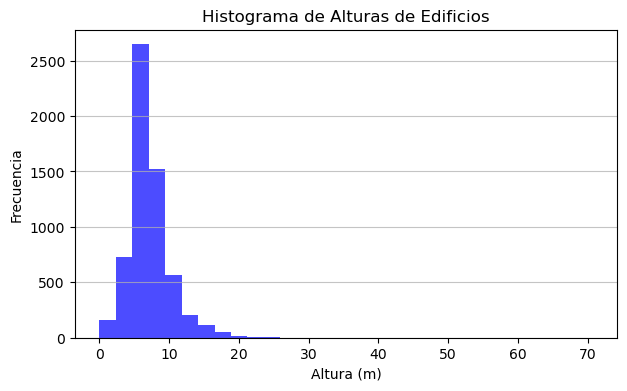

In [5]:
# histograma de alturas
plt.figure(figsize=(7, 4))
plt.hist(altura_edi['altura'], bins=30, color='blue', alpha=0.7)
plt.title('Histograma de Alturas de Edificios')
plt.xlabel('Altura (m)')
plt.ylabel('Frecuencia')
plt.grid(axis='y', alpha=0.75)
plt.show()

### Calcular longitud de sombra por edificio

In [6]:
# Convertir elevación solar a radianes
elev_rad = np.radians(elevacion_sol)

# Evitar división por cero (sol muy bajo o noche)
altura_edi['long_sombra'] = altura_edi['altura'] / np.tan(elev_rad)


### Proyectar la sombra como polígonos

In [7]:
from shapely.affinity import translate
import math

# Convertir azimut a radianes
azimut_rad = np.radians(azimut_sol)

# Dirección (dx, dy) hacia donde se proyecta la sombra
dx = np.sin(azimut_rad)
dy = np.cos(azimut_rad)

# Proyectar geometrías
def proyectar_sombra(row):
    dist = row['long_sombra']
    geom = row.geometry
    return translate(geom, xoff=dx * dist, yoff=dy * dist)

# Crear nueva columna con sombra proyectada
altura_edi['sombra_geom'] = altura_edi.apply(proyectar_sombra, axis=1)


### Exportar o visualizar las sombras

In [8]:
# Crear un GeoDataFrame de sombras
sombras = gpd.GeoDataFrame(geometry=altura_edi['sombra_geom'], crs="EPSG:32719")

# Exportar a shapefile
sombras.to_file("sombras_proyectadas.shp")


In [9]:
print(sombras.crs)

EPSG:32719


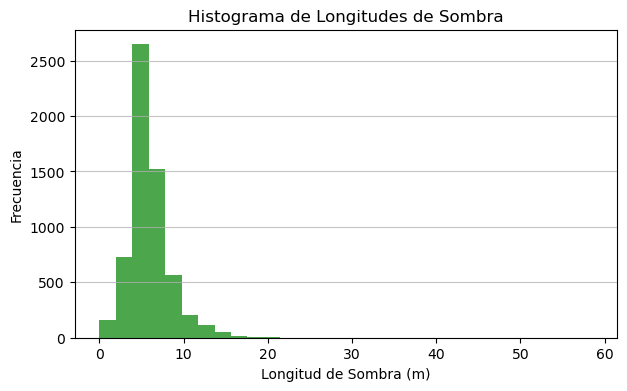

In [10]:
# histograma de longitudes de sombra
plt.figure(figsize=(7, 4))
plt.hist(altura_edi['long_sombra'], bins=30, color='green', alpha=0.7)
plt.title('Histograma de Longitudes de Sombra')
plt.xlabel('Longitud de Sombra (m)')
plt.ylabel('Frecuencia')
plt.grid(axis='y', alpha=0.75)
plt.show()

## NDVI

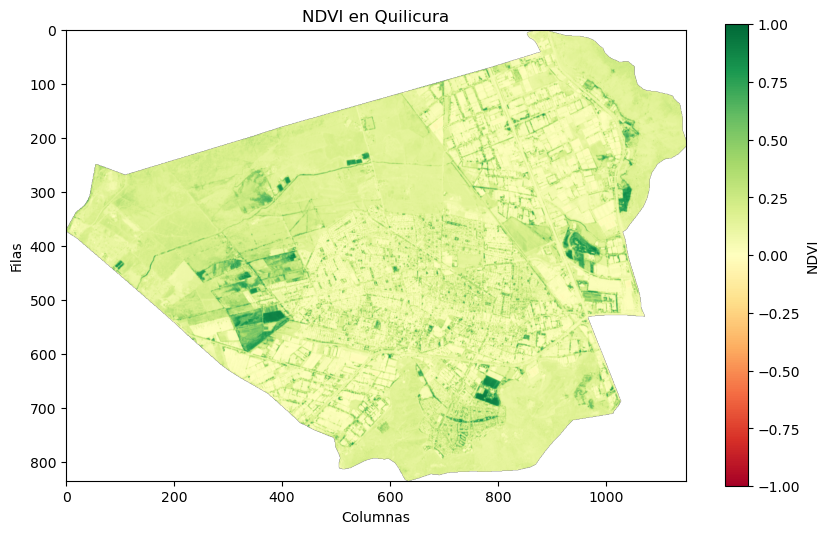

In [11]:
# cargar tif de ndvi
import rasterio
# Cargar el archivo NDVI exportado
ndvi_filepath = 'Quilicura_NDVI_20231201_20240331.tif'  # Ajusta según el nombre del archivo exportado
ndvi_image = rasterio.open(ndvi_filepath)
# Leer los datos NDVI
ndvi_data = ndvi_image.read(1)  # Leer la primera banda (NDVI)
# Cerrar el archivo
ndvi_image.close()
# Visualizar el NDVI usando matplotlib
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.imshow(ndvi_data, cmap='RdYlGn', vmin=-1, vmax=1)
plt.colorbar(label='NDVI')
plt.title('NDVI en Quilicura')
plt.xlabel('Columnas')
plt.ylabel('Filas')
plt.show()

In [ ]:
# Abrir el raster
with rasterio.open('Quilicura_NDVI_20231201_20240331.tif') as src:
    ndvi = src.read(1)
    mask = ~np.isnan(ndvi)
    ndvi_crs = src.crs
    ndvi_transform = src.transform

# Generar formas (polígonos)
shapes_generator = shapes(ndvi, mask=mask, transform=ndvi_transform)

# Convertir a geometría y valores
records = [{'geometry': shape(geom), 'ndvi': value} for geom, value in shapes_generator]

# Crear GeoDataFrame
ndvi = gpd.GeoDataFrame(records, crs="EPSG:32719") #crs=ndvi_crs)

# Guardar shapefile
ndvi.to_file('ndvi_polygons.shp')

In [21]:
# leer archivo shp con ndvi
ndvi = gpd.read_file('ndvi_polygons.shp')
ndvi.head()

ndvi                                           geometry
0  0.057720  POLYGON ((340960 6312150, 340970 6312150, 3409...
1  0.052265  POLYGON ((340970 6312150, 340980 6312150, 3409...
2  0.069586  POLYGON ((340980 6312150, 340990 6312150, 3409...
3  0.075805  POLYGON ((340990 6312150, 341000 6312150, 3410...
4  0.049927  POLYGON ((340910 6312140, 340920 6312140, 3409...

## Temperatura

In [22]:
# # Inicializar la API de Google Earth Engine
# import ee
# ee.Initialize(project='proyecto-2023-407915')

In [23]:

# # --- Configuración Inicial ---
# place_name = "Quilicura, Santiago, Chile"
# GOOGLE_CLOUD_PROJECT_ID = 'proyecto-2023-407915'

# # --- Parámetros para la Temperatura de Superficie Terrestre (LST) ---
# # Período de tiempo para buscar imágenes (ej. verano austral 2023-2024)
# START_DATE = '2023-12-01'
# END_DATE = '2024-03-31' # Fines de marzo de 2024

# # Umbral de porcentaje de nubes para filtrar imágenes (0 a 100)
# # Un valor más bajo significa menos nubes, pero menos imágenes disponibles.
# MAX_CLOUD_PERCENTAGE = 20 # Por ejemplo, 20% de nubes máximo

# # Resolución de exportación del ráster (en metros)
# # Las bandas térmicas de Landsat 8 tienen 30m de resolución nativa.
# EXPORT_SCALE_METERS = 30 # Cambiado a 30m para Landsat 8

# # --- 1. Inicializar Google Earth Engine ---
# try:
#     ee.Initialize(project=GOOGLE_CLOUD_PROJECT_ID)
#     print("Google Earth Engine inicializado correctamente.")
# except Exception as e:
#     print(f"Error al inicializar Earth Engine: {e}")
#     print("Asegúrate de haber ejecutado 'ee.Authenticate()' y seguido los pasos de autenticación.")
#     print("Si estás en un entorno como Jupyter, es posible que necesites reiniciar el kernel después de la autenticación.")
#     exit()

# # --- 2. Definir la Región de Interés (ROI) para Quilicura ---
# print("\nObteniendo límites de Quilicura desde OpenStreetMap con OSMnx...")
# try:
#     place_gdf = ox.geocode_to_gdf(place_name)
#     quilicura_polygon_shapely = place_gdf.geometry.iloc[0]
#     roi = ee.Geometry.Polygon(list(quilicura_polygon_shapely.exterior.coords))
#     print("Límites de Quilicura obtenidos de OSMnx.")
# except Exception as e:
#     print(f"No se pudieron obtener los límites de Quilicura con OSMnx: {e}")
#     print("Usando un polígono predefinido aproximado para Quilicura como respaldo. ¡Considera obtener uno más preciso!")
#     quilicura_coords_approx = [
#         [-70.77, -33.32],
#         [-70.77, -33.40],
#         [-70.70, -33.40],
#         [-70.70, -33.32],
#         [-70.77, -33.32]
#     ]
#     roi = ee.Geometry.Polygon(quilicura_coords_approx)

# # --- 3. Cargar y filtrar la colección de imágenes Landsat 8 ---
# # Dataset de Landsat 8 Collection 2 Tier 1 para LST
# # Bandas de interés: 'ST_B10' (Temperatura de la Superficie Terrestre en Kelvin * 10), 'QA_PIXEL' para nubes
# LS8_COLLECTION = 'LANDSAT/LC08/C02/T1_L2'
# print(f"\nCargando la colección de imágenes Landsat 8 ({LS8_COLLECTION})...")

# # Filtrar por fecha y región de interés
# collection = ee.ImageCollection(LS8_COLLECTION) \
#     .filterDate(START_DATE, END_DATE) \
#     .filterBounds(roi)

# # --- 4. Aplicar máscara de nubes y escalar la banda térmica ---
# # Función para enmascarar nubes y escalar la banda de temperatura
# def mask_and_scale_landsat_lst(image):
#     # Seleccionar la banda QA_PIXEL para la información de nubes y nieve/hielo
#     qa_pixel = image.select('QA_PIXEL')

#     # Bits de la banda QA_PIXEL para nubes, cirros y sombra de nubes (Landsat 8 C2 T1)
#     # Bit 3: Cloud shadow
#     # Bit 5: Clouds
#     # Bit 7: Cirrus
#     cloud_shadow_bit_mask = (1 << 3)
#     clouds_bit_mask = (1 << 5)
#     cirrus_bit_mask = (1 << 7)

#     # Ambos deben ser 0 para un píxel claro.
#     mask = qa_pixel.bitwiseAnd(cloud_shadow_bit_mask).eq(0) \
#         .And(qa_pixel.bitwiseAnd(clouds_bit_mask).eq(0)) \
#         .And(qa_pixel.bitwiseAnd(cirrus_bit_mask).eq(0))

#     # Seleccionar la banda de temperatura (ST_B10) y aplicar el factor de escala
#     # ST_B10 está en Kelvin * 10
#     lst = image.select('ST_B10').multiply(0.00341802).add(149.0).subtract(273.15).rename('LST') # Convertir a Celsius

#     return image.addBands(lst).updateMask(mask)

# print("Aplicando máscara de nubes y escalando la banda LST a Celsius...")
# collection_processed = collection.map(mask_and_scale_landsat_lst)

# # --- Verificación crucial: Asegurarse de que la colección no esté vacía ---
# num_images_final = collection_processed.size().getInfo()
# if num_images_final == 0:
#     print(f"ADVERTENCIA: No se encontraron imágenes Landsat 8 claras para Quilicura en el período {START_DATE} a {END_DATE} con el umbral de nubes del {MAX_CLOUD_PERCENTAGE}%.")
#     print("Intenta ajustar las fechas (a un período de menos nubes) o aumentar el MAX_CLOUD_PERCENTAGE.")
#     exit()
# else:
#     print(f"Se encontraron {num_images_final} imágenes Landsat 8 claras después del filtrado y procesamiento.")

# # --- 5. Crear un mosaico LST compuesto (ej. mediana) ---
# # Usar la mediana para reducir ruido y minimizar efectos de nubes residuales.
# print("Creando un mosaico LST compuesto (mediana) para la ROI...")
# # Seleccionar solo la banda LST para el mosaico final
# lst_composite = collection_processed.select('LST').median().clip(roi)

# # --- 6. Exportar el ráster LST a Google Drive ---
# # Definir los parámetros de exportación
# output_filename = f'Quilicura_LST_{START_DATE.replace("-","")}_{END_DATE.replace("-","")}'

# print(f"\nPreparando la exportación del ráster LST a Google Drive como '{output_filename}.tif'...")

# # Tarea de exportación asíncrona
# task = ee.batch.Export.image.toDrive(
#     image=lst_composite,
#     description=output_filename,
#     folder='GEE_Exports_LST', # Nueva carpeta específica para LST
#     fileNamePrefix=output_filename,
#     scale=EXPORT_SCALE_METERS,
#     crs='EPSG:32719',   # CRS UTM zona 19S (Santiago)
#     maxPixels=1e10
# )

# task.start()

# print(f"Tarea de exportación de LST a Google Drive iniciada. Revisa la pestaña 'Tasks' en el Code Editor de GEE para monitorear '{task.id}'.")
# print("El archivo GeoTIFF se guardará en tu Google Drive cuando la tarea finalice.")
# print("\nProceso de generación de LST completado.")

### Visualizar mapa de temperatura

In [24]:
# Cargar el mapa de temperatura
LST_filepath = 'Quilicura_LST_20231201_20240331.tif' 
LST_image = rasterio.open(LST_filepath)
# Leer los datos
LST_data = LST_image.read(1)
# Cerrar el archivo
LST_image.close()

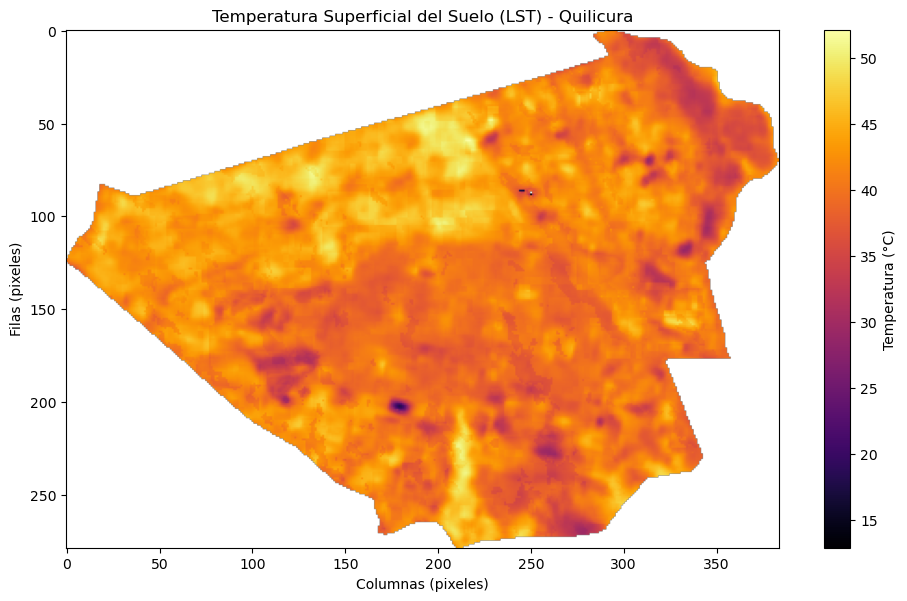

In [25]:
# Visualizar con matplotlib
plt.figure(figsize=(10, 6))
plt.imshow(LST_data, cmap='inferno')  # Colormap ideal para temperatura
plt.colorbar(label='Temperatura (°C)')
plt.title('Temperatura Superficial del Suelo (LST) - Quilicura')
plt.xlabel('Columnas (pixeles)')
plt.ylabel('Filas (pixeles)')
plt.tight_layout()
plt.show()

In [26]:
# Abrir el raster de temperatura
with rasterio.open('Quilicura_LST_20231201_20240331.tif') as src:
    lst_data = src.read(1)
    mask = ~np.isnan(lst_data)
    lst_crs = src.crs
    lst_transform = src.transform

# Generar formas (polígonos) para celdas con datos
shapes_generator = shapes(lst_data, mask=mask, transform=lst_transform)

# Convertir a lista de diccionarios con geometría y valor
records = [{'geometry': shape(geom), 'temperature': value} for geom, value in shapes_generator]

# Crear GeoDataFrame
temp = gpd.GeoDataFrame(records, crs="EPSG:32719") #crs=lst_crs)

# Guardar como shapefile
temp.to_file('temperatura_poligonos.shp')


C:\Users\cj_li\AppData\Local\Temp\ipykernel_12688\1713035896.py:18: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  temp.to_file('temperatura_poligonos.shp')
c:\Users\cj_li\anaconda3\envs\ox\Lib\site-packages\pyogrio\raw.py:723: RuntimeWarning: Normalized/laundered field name: 'temperature' to 'temperatur'
  ogr_write(


In [27]:
temp.head()

geometry  temperature
0  POLYGON ((340890 6312150, 340890 6312120, 3409...    41.524849
1  POLYGON ((340920 6312150, 340920 6312120, 3409...    41.644478
2  POLYGON ((340950 6312150, 340950 6312120, 3409...    41.832470
3  POLYGON ((340980 6312150, 340980 6312120, 3410...    41.815380
4  POLYGON ((341010 6312150, 341010 6312120, 3410...    41.453068

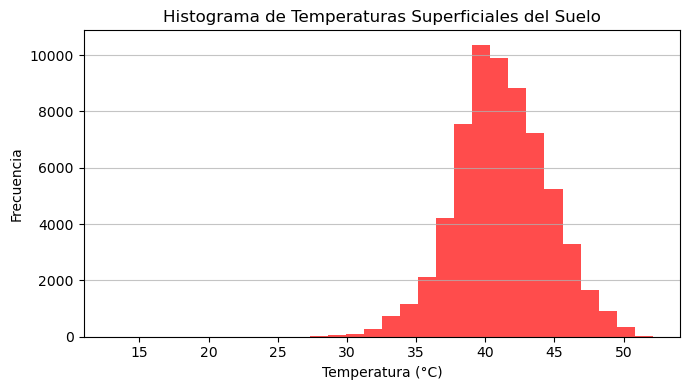

In [28]:
# Histograma de temperaturas
plt.figure(figsize=(7, 4))
plt.hist(LST_data[~np.isnan(LST_data)], bins=30, color='red', alpha=0.7)
plt.title('Histograma de Temperaturas Superficiales del Suelo')
plt.xlabel('Temperatura (°C)')
plt.ylabel('Frecuencia')
plt.grid(axis='y', alpha=0.75)
plt.tight_layout()
plt.show()

## Revisar SRC de los GDF de temperatura y NDVI

In [29]:
# revisar el SRC de altura_edi
print(altura_edi.crs)
# revisar el SRC de los GDF de temperatura y NDVI
print(temp.crs)
print(ndvi.crs)


PROJCRS["WGS 84 / UTM zone 19S",BASEGEOGCRS["WGS 84",DATUM["World Geodetic System 1984",ELLIPSOID["WGS 84",6378137,298.257223563,LENGTHUNIT["metre",1]],ID["EPSG",6326]],PRIMEM["Greenwich",0,ANGLEUNIT["Degree",0.0174532925199433]]],CONVERSION["UTM zone 19S",METHOD["Transverse Mercator",ID["EPSG",9807]],PARAMETER["Latitude of natural origin",0,ANGLEUNIT["Degree",0.0174532925199433],ID["EPSG",8801]],PARAMETER["Longitude of natural origin",-69,ANGLEUNIT["Degree",0.0174532925199433],ID["EPSG",8802]],PARAMETER["Scale factor at natural origin",0.9996,SCALEUNIT["unity",1],ID["EPSG",8805]],PARAMETER["False easting",500000,LENGTHUNIT["metre",1],ID["EPSG",8806]],PARAMETER["False northing",10000000,LENGTHUNIT["metre",1],ID["EPSG",8807]],ID["EPSG",16119]],CS[Cartesian,3],AXIS["(E)",east,ORDER[1],LENGTHUNIT["metre",1,ID["EPSG",9001]]],AXIS["(N)",north,ORDER[2],LENGTHUNIT["metre",1,ID["EPSG",9001]]],AXIS["ellipsoidal height (h)",up,ORDER[3],LENGTHUNIT["metre",1,ID["EPSG",9001]]]]
EPSG:32719
EPSG:3271

## Grafo de calles

In [30]:
import osmnx as ox
import networkx as nx
import folium

# Nombre del lugar
place_name = 'Quilicura, Santiago, Chile'

# Obtener el grafo de la red peatonal
G = ox.graph_from_place(place_name, network_type='walk')

# Convertir a GeoDataFrame para trabajar con tramos de calle (edges)
#edges = ox.graph_to_gdfs(G, nodes=False)
nodes, edges = ox.graph_to_gdfs(G)

In [31]:
edges_utm = edges.to_crs(epsg=32719)

In [32]:
edges_utm.head(2)

osmid      highway lanes                    name  \
u         v         key                                                         
267441235 267441476 0    485038015  residential     2  Guardiamarina Riquelme   
          267443636 0     24602513  residential     2     Manuel Antonio Romo   

                         oneway reversed      length  \
u         v         key                                
267441235 267441476 0     False     True   68.073403   
          267443636 0     False    False  161.269543   

                                                                  geometry  \
u         v         key                                                      
267441235 267441476 0    LINESTRING (338220.512 6306501.828, 338287.605...   
          267443636 0    LINESTRING (338220.512 6306501.828, 338218.987...   

                        maxspeed bridge service  ref junction access width  \
u         v         key                                                      
267441235 267441476 0        NaN    NaN     NaN  NaN      NaN    NaN   NaN   
          267443636 0        NaN    NaN     NaN  NaN      NaN    NaN   NaN   

                        tunnel  
u         v         key         
267441235 267441476 0      NaN  
          267443636 0      NaN

In [33]:
# visualizar el grafo en un mapa interactivo
m = folium.Map(location=[-33.4, -70.7], zoom_start=13)
folium.GeoJson(edges.geometry).add_to(m)
m

## Calcular el porcentaje de sombra en cada tramo

In [34]:
# Asegurar que el grafo tengo un id único para cada tramo
edges_utm = edges_utm.reset_index(drop=True)
edges_utm["edge_id"] = edges_utm.index

In [35]:
edges_utm

osmid      highway lanes                    name  \
0                     485038015  residential     2  Guardiamarina Riquelme   
1                      24602513  residential     2     Manuel Antonio Romo   
2                      24602513  residential     2     Manuel Antonio Romo   
3                     485031746  residential     2  Guardiamarina Riquelme   
4                      24602249  residential     2                 Serrano   
...                         ...          ...   ...                     ...   
19881  [1388875928, 1388875927]      footway   NaN                     NaN   
19882                1288965172      footway   NaN                     NaN   
19883                1288965172      footway   NaN                     NaN   
19884  [1388875928, 1388875927]      footway   NaN                     NaN   
19885  [1288965169, 1181902526]      service   NaN                     NaN   

       oneway       reversed      length  \
0       False           True   68.073403   
1       False          False  161.269543   
2       False           True  223.334129   
3       False          False   55.394629   
4       False           True  161.127562   
...       ...            ...         ...   
19881   False  [False, True]   84.528386   
19882   False          False   15.578428   
19883   False           True   30.924237   
19884   False  [False, True]   84.528386   
19885   False           True   41.894550   

                                                geometry maxspeed bridge  \
0      LINESTRING (338220.512 6306501.828, 338287.605...      NaN    NaN   
1      LINESTRING (338220.512 6306501.828, 338218.987...      NaN    NaN   
2      LINESTRING (338220.512 6306501.828, 338222.21 ...      NaN    NaN   
3      LINESTRING (338220.512 6306501.828, 338217.189...      NaN    NaN   
4      LINESTRING (338504.274 6306280.39, 338504.782 ...      NaN    NaN   
...                                                  ...      ...    ...   
19881  LINESTRING (338977.262 6306648.413, 338989.526...      NaN    NaN   
19882  LINESTRING (338959.417 6306578.637, 338945.516...      NaN    NaN   
19883  LINESTRING (338959.417 6306578.637, 338987.012...      NaN    NaN   
19884  LINESTRING (338959.417 6306578.637, 338989.526...      NaN    NaN   
19885  LINESTRING (338975.96 6306557.039, 338960.726 ...      NaN    NaN   

      service  ref junction     access width tunnel  edge_id  
0         NaN  NaN      NaN        NaN   NaN    NaN        0  
1         NaN  NaN      NaN        NaN   NaN    NaN        1  
2         NaN  NaN      NaN        NaN   NaN    NaN        2  
3         NaN  NaN      NaN        NaN   NaN    NaN        3  
4         NaN  NaN      NaN        NaN   NaN    NaN        4  
...       ...  ...      ...        ...   ...    ...      ...  
19881     NaN  NaN      NaN        NaN   NaN    NaN    19881  
19882     NaN  NaN      NaN        NaN   NaN    NaN    19882  
19883     NaN  NaN      NaN        NaN   NaN    NaN    19883  
19884     NaN  NaN      NaN        NaN   NaN    NaN    19884  
19885     NaN  NaN      NaN  customers   NaN    NaN    19885  

[19886 rows x 17 columns]

In [36]:
from geopandas import overlay

# Intersección geométrica con geopandas overlay
edges_sombra_intersect = overlay(edges_utm, sombras, how='intersection')


In [37]:
# Longitud de sombra en cada tramo
# Longitud total de cada tramo (en metros)
edges_utm["long_total"] = edges_utm.geometry.length

# Longitud de cada intersección con sombra
edges_sombra_intersect["long_sombra"] = edges_sombra_intersect.geometry.length


In [38]:
# Calcular la longitud sombreada
sombra_por_tramo = edges_sombra_intersect.groupby("edge_id")["long_sombra"].sum().reset_index()

In [39]:
sombra_por_tramo

edge_id  long_sombra
0          1    17.634830
1        150     7.419428
2        183     7.419428
3        223    17.634830
4        309    14.417274
..       ...          ...
957    19881    65.317651
958    19882     4.373686
959    19883    14.333308
960    19884    65.317651
961    19885    23.090312

[962 rows x 2 columns]

In [40]:
# Calcular el porcentaje de sombra en cada tramo
# Combinar con los tramos originales
edges_utm = edges_utm.merge(sombra_por_tramo, on="edge_id", how="left")

# Rellenar NaN con 0 (tramos sin sombra)
edges_utm["long_sombra"] = edges_utm["long_sombra"].fillna(0)

# Porcentaje de sombra (0 a 1)
edges_utm["pct_sombra"] = edges_utm["long_sombra"] / edges_utm["long_total"]


In [41]:
edges_utm.drop(['maxspeed', 'bridge', 'service', 'ref', 'junction', 'access', 'width', 'tunnel'], axis=1, inplace=True)

## Cruzar la información ambiental con las calles de OSM

In [46]:
temp.rename(columns={'temperature': 'valor'}, inplace=True)
ndvi.rename(columns={'ndvi': 'valor'}, inplace=True)

In [48]:
def asignar_promedio_por_interseccion(edges, gdf_poligono, nombre_variable, columna_valor='valor'):
    # Asegurar mismo CRS
    gdf_poligono = gdf_poligono.to_crs(edges.crs)

    # Spatial join
    joined = gpd.sjoin(edges, gdf_poligono[[columna_valor, 'geometry']], how='left', predicate='intersects')

    # Agrupar por edge_id y calcular promedio
    resumen = joined.groupby('edge_id')[columna_valor].mean().reset_index()
    resumen = resumen.rename(columns={columna_valor: nombre_variable})

    # Combinar de nuevo con edges
    edges = edges.merge(resumen, on='edge_id', how='left')

    return edges


In [49]:
edges_ndvi_temp = asignar_promedio_por_interseccion(edges_utm, temp, 'temperatura')
edges_final = asignar_promedio_por_interseccion(edges_ndvi_temp, ndvi, 'ndvi')


In [50]:
# Exportar a shapefile
edges_final.to_file('edges_final.shp')

C:\Users\cj_li\AppData\Local\Temp\ipykernel_12688\3925749562.py:2: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  edges_final.to_file('edges_final.shp')
c:\Users\cj_li\anaconda3\envs\ox\Lib\site-packages\pyogrio\raw.py:723: RuntimeWarning: Normalized/laundered field name: 'long_sombra' to 'long_sombr'
  ogr_write(
c:\Users\cj_li\anaconda3\envs\ox\Lib\site-packages\pyogrio\raw.py:723: RuntimeWarning: Normalized/laundered field name: 'temperatura' to 'temperatur'
  ogr_write(


## Generación sintética de perfiles de usuario y valoración de comodidad

In [51]:
# Asignar perfiles de usuario sintéticos
np.random.seed(42)

edges_final['perfil_usuario'] = np.random.choice(['joven', 'anciano', 'madre', 'deportista'], len(edges_final))

In [52]:
edges_final

osmid      highway lanes                    name  \
0                     485038015  residential     2  Guardiamarina Riquelme   
1                      24602513  residential     2     Manuel Antonio Romo   
2                      24602513  residential     2     Manuel Antonio Romo   
3                     485031746  residential     2  Guardiamarina Riquelme   
4                      24602249  residential     2                 Serrano   
...                         ...          ...   ...                     ...   
19881  [1388875928, 1388875927]      footway   NaN                     NaN   
19882                1288965172      footway   NaN                     NaN   
19883                1288965172      footway   NaN                     NaN   
19884  [1388875928, 1388875927]      footway   NaN                     NaN   
19885  [1288965169, 1181902526]      service   NaN                     NaN   

       oneway       reversed      length  \
0       False           True   68.073403   
1       False          False  161.269543   
2       False           True  223.334129   
3       False          False   55.394629   
4       False           True  161.127562   
...       ...            ...         ...   
19881   False  [False, True]   84.528386   
19882   False          False   15.578428   
19883   False           True   30.924237   
19884   False  [False, True]   84.528386   
19885   False           True   41.894550   

                                                geometry  edge_id  long_total  \
0      LINESTRING (338220.512 6306501.828, 338287.605...        0   68.201059   
1      LINESTRING (338220.512 6306501.828, 338218.987...        1  160.850305   
2      LINESTRING (338220.512 6306501.828, 338222.21 ...        2  222.768992   
3      LINESTRING (338220.512 6306501.828, 338217.189...        3   55.397701   
4      LINESTRING (338504.274 6306280.39, 338504.782 ...        4  160.718272   
...                                                  ...      ...         ...   
19881  LINESTRING (338977.262 6306648.413, 338989.526...    19881   84.421160   
19882  LINESTRING (338959.417 6306578.637, 338945.516...    19882   15.594340   
19883  LINESTRING (338959.417 6306578.637, 338987.012...    19883   30.955829   
19884  LINESTRING (338959.417 6306578.637, 338989.526...    19884   84.421160   
19885  LINESTRING (338975.96 6306557.039, 338960.726 ...    19885   41.826058   

       long_sombra  pct_sombra  temperatura      ndvi perfil_usuario  
0         0.000000    0.000000    39.274651  0.187979          madre  
1        17.634830    0.109635    39.326084  0.245129     deportista  
2         0.000000    0.000000    38.521166  0.215206          joven  
3         0.000000    0.000000    39.198030  0.176634          madre  
4         0.000000    0.000000    39.130768  0.209419          madre  
...            ...         ...          ...       ...            ...  
19881    65.317651    0.773712    40.103806  0.102502     deportista  
19882     4.373686    0.280466    39.668861  0.182192          joven  
19883    14.333308    0.463025    40.293221  0.127664     deportista  
19884    65.317651    0.773712    40.103806  0.102502     deportista  
19885    23.090312    0.552056    39.737223  0.112450     deportista  

[19886 rows x 15 columns]

In [53]:
import numpy as np

# Coeficientes de penalización/bonificación según perfil
penalización = {
    'joven': 0.0,
    'madre': -5,
    'anciano': -10,
    'deportista': -2
}

# Número de filas del DataFrame
n = len(edges_final)

# Aplicamos la penalización al cálculo sintético
edges_final['comodidad'] = (
    0.3 * (100 - edges_final['temperatura']) +
    0.4 * edges_final['pct_sombra'] * 100 +  # corregido nombre de columna y escalar a 0-100
    0.2 * edges_final['ndvi'] * 100 +
    edges_final['perfil_usuario'].map(penalización).fillna(0) +  # evitar NaNs
    np.random.normal(0, 5, n)
) / 100


In [55]:
edges_final['peso_ruta'] = (1 - edges_final['comodidad']) 

### Restaurar el Grafo

In [56]:
edges['edge_id'] = range(len(edges))

In [57]:
# Unir datos de edges_final con edges originales
# Hacemos el merge para mantener la geometría original (con u, v, key)

edges_final_reconstruido = edges.reset_index().merge(
    edges_final[['edge_id', 'pct_sombra', 'temperatura', 'ndvi', 'perfil_usuario', 'comodidad', 'peso_ruta']],
    on='edge_id',
    how='left'
).set_index(['u', 'v', 'key'])


In [58]:
G_nuevo = ox.graph_from_gdfs(nodes, edges_final_reconstruido)


In [65]:
edges_final_reconstruido.head()

osmid      highway lanes                    name  \
u         v         key                                                         
267441235 267441476 0    485038015  residential     2  Guardiamarina Riquelme   
          267443636 0     24602513  residential     2     Manuel Antonio Romo   
          267443633 0     24602513  residential     2     Manuel Antonio Romo   
          267443695 0    485031746  residential     2  Guardiamarina Riquelme   
267441252 267441471 0     24602249  residential     2                 Serrano   

                         oneway reversed      length  \
u         v         key                                
267441235 267441476 0     False     True   68.073403   
          267443636 0     False    False  161.269543   
          267443633 0     False     True  223.334129   
          267443695 0     False    False   55.394629   
267441252 267441471 0     False     True  161.127562   

                                                                  geometry  \
u         v         key                                                      
267441235 267441476 0    LINESTRING (-70.73898 -33.36857, -70.73826 -33...   
          267443636 0    LINESTRING (-70.73898 -33.36857, -70.739 -33.3...   
          267443633 0    LINESTRING (-70.73898 -33.36857, -70.73896 -33...   
          267443695 0    LINESTRING (-70.73898 -33.36857, -70.73902 -33...   
267441252 267441471 0    LINESTRING (-70.73597 -33.37061, -70.73597 -33...   

                        maxspeed bridge  ... access width tunnel edge_id  \
u         v         key                  ...                               
267441235 267441476 0        NaN    NaN  ...    NaN   NaN    NaN       0   
          267443636 0        NaN    NaN  ...    NaN   NaN    NaN       1   
          267443633 0        NaN    NaN  ...    NaN   NaN    NaN       2   
          267443695 0        NaN    NaN  ...    NaN   NaN    NaN       3   
267441252 267441471 0        NaN    NaN  ...    NaN   NaN    NaN       4   

                        pct_sombra temperatura      ndvi  perfil_usuario  \
u         v         key                                                    
267441235 267441476 0     0.000000   39.274651  0.187979           madre   
          267443636 0     0.109635   39.326084  0.245129      deportista   
          267443633 0     0.000000   38.521166  0.215206           joven   
          267443695 0     0.000000   39.198030  0.176634           madre   
267441252 267441471 0     0.000000   39.130768  0.209419           madre   

                         comodidad  peso_ruta  
u         v         key                        
267441235 267441476 0     0.106578   0.893422  
          267443636 0     0.303303   0.696697  
          267443633 0     0.186904   0.813096  
          267443695 0     0.108592   0.891408  
267441252 267441471 0     0.178858   0.821142  

[5 rows x 23 columns]

In [59]:
nodos = list(G_nuevo.nodes)

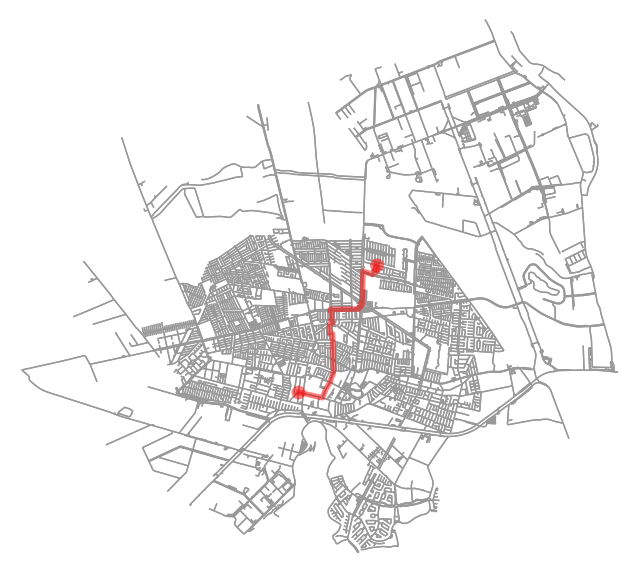

(<Figure size 800x800 with 1 Axes>, <Axes: >)

In [67]:
# Paso 6: Seleccionar dos nodos y calcular ruta más cómoda
# orig = ox.nearest_nodes(G, X=-70.738981, Y=-33.368567)  # coordenadas ficticias
# dest = ox.nearest_nodes(G, X=-70.735972, Y=-33.370607)

orig = nodos[0]  # Selecciona el primer nodo como origen
dest = nodos[500]  # Selecciona el segundo nodo como destino

ruta = nx.shortest_path(G_nuevo, source=orig, target=dest, weight='comodidad')

# Paso 7: Visualizar
ox.plot_graph_route(G, ruta, route_linewidth=4, node_size=0, bgcolor='white')

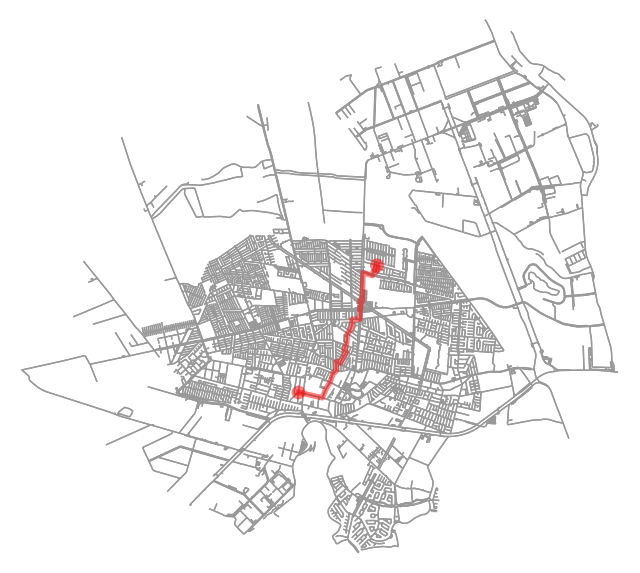

(<Figure size 800x800 with 1 Axes>, <Axes: >)

In [ ]:
# Paso 7: Comparar con ruta más corta

orig = nodos[0]  # Selecciona el primer nodo como origen
dest = nodos[500]  # Selecciona el segundo nodo como destino

ruta = nx.shortest_path(G_nuevo, source=orig, target=dest, weight= None)

# Paso 7: Visualizar
ox.plot_graph_route(G, ruta, route_linewidth=4, node_size=0, bgcolor='white')